### pyAPES_MLM: Multi-layer soil-vegetation-atmosphere transfer model

Demo how to:
1. Set-up the model
1. Run the model
1. Retrieve the results using xarray

In [2]:
# setting path
import sys
#sys.path.append('c:\\Repositories\\pyAPES_main')
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')

sys.path.append(pyAPES_main_folder)
#print(sys.path)

### Import modules

In [3]:
# function to read forcing data. See 'forcing/forcing_info.txt' for model forcing variable names and units!
from pyAPES.utils.iotools import read_forcing

# import the multi-layer model (mlm) driver
from pyAPES.pyAPES_mlm import driver

# mlm setup (parameterization, forcing file & run info) defined in: pyAPES.models.mlm_parameters
# output variables & logger configuration defined in: pyAPES.models.mlm_outputs (read by driver)

from pyAPES.parameters.mlm_parameters import gpara, cpara, spara # model configuration, canopy parameters, soil parameters


In [4]:
gpara['forc_filename'],

('c:/Repositories/pyAPES_main/forcing/Hyytiala/FIHy_forcing_2006_2008.dat',)

### Read forcing data and compile input for driver

In [5]:
forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

params = {
    'general': gpara,   # model configuration
    'canopy': cpara,    # planttype, micromet, canopy, bottomlayer parameters
    'soil': spara,      # soil heat and water flow parameters
    'forcing': forcing  # forging data
}

### Run the model

In [6]:
resultfile, Model = driver(parameters=params,
                           create_ncf=True,
                           result_file= 'testrun.nc'
                          )

# alternative (for testing over short periods) is to return resuts in dictionary 'results'
# results, Model = driver(parameters=params,
#                         create_ncf=False,
#                         result_file=None
#                          )

INFO pyAPES.pyAPES_mlm driver pyAPES_MLM simulation started. Number of simulations: 1
INFO pyAPES.soil.water __init__ Water balance in soil solved using: RICHARDS EQUATION & no lateral drainage
INFO pyAPES.soil.heat __init__ Soil heat balance solved.
INFO pyAPES.canopy.mlm_canopy __init__ Eflow: True, WMA: False, Ebal: True
INFO pyAPES.microclimate.radiation __init__ Shortwave radiation model: ZHAOQUALLS
INFO pyAPES.microclimate.radiation __init__ Longwave radiation model: ZHAOQUALLS
C:\Repositories\pyAPES_main\pyAPES\bottomlayer\organiclayer.py:1172: RuntimeWarning: invalid value encountered in power
  Psi = -1e-2 / alfa*(s**(1.0 / m) - 1.0)**(1.0 / n)  # m
INFO pyAPES.canopy.forestfloor __init__ Forestfloor has 1 bottomlayer types
INFO pyAPES.pyAPES_mlm driver Running simulation number (start time 2023-10-03 13:42): 0
INFO pyAPES.pyAPES_mlm run Running simulation 0


0%.. 10%.. 20%.. 30%.. 40%.. 50%.. 60%.. 70%.. 80%.. 90%.. 

INFO pyAPES.pyAPES_mlm run Finished simulation 0, running time 30.22 seconds
INFO pyAPES.pyAPES_mlm driver Running time 30.22 seconds
INFO pyAPES.pyAPES_mlm driver Ready! Results are in: results/testrun.nc


100%


### Read results using xarray



In [7]:
from pyAPES.utils.iotools import read_results
import matplotlib.pyplot as plt

# read simulation restuls to xarray dataset
results = read_results(resultfile)

### Print resuts metadata:

Output variables according to those defined at mlm_outputs. Each contains one or several of following dimensions:

- date --> time dimension
- simulation --> simulation number. If there is only one, remember that it has index 0!
- canopy --> canopy layers. Index is 0 at ground and increases upwards
- planttype --> planttypes defined in mlm_parameters. Index follows the order in dict cpara['planttypes']) 
- soil -> soil layers. Index 0 is at the top and increases downwards (nr soil layers, 0 at top)
- groundtype --> groundtypes at forestfloor; defined in mlm_parameters. Index follows the order in dict: cpara['forestfloor']['bottom_layer_types']


In [8]:
print(results)

# print list of all variables:
#vars = list(results.data_vars)
#for v in vars:
#    print(v)

<xarray.Dataset>
Dimensions:                             (date: 433, simulation: 1, canopy: 101,
                                         planttype: 2, soil: 44, groundtype: 1)
Coordinates:
  * date                                (date) datetime64[ns] 2006-06-01 ... ...
  * simulation                          (simulation) int64 0
  * soil                                (soil) float32 -0.005 -0.015 ... -1.95
  * canopy                              (canopy) float32 0.0 0.25 ... 24.75 25.0
Dimensions without coordinates: planttype, groundtype
Data variables: (12/156)
    forcing_air_temperature             (date, simulation) float32 ...
    forcing_precipitation               (date, simulation) float32 ...
    forcing_pressure                    (date, simulation) float32 ...
    forcing_h2o                         (date, simulation) float32 ...
    forcing_co2                         (date, simulation) float32 ...
    forcing_wind_speed                  (date, simulation) float32 ...
   

### Plot some model results

In [9]:
sim = 0  # in this demo, we have only one simulation (i.e. parameter set)

# grid
t = results.date  # time
zc = results.canopy_z  # height above ground [m]
zs = results.soil_z  # depth of soil; shown negative [m]


### Soil temperature and moisture

- computed using pyAPES.soil - package submodels 'Water' and 'Heat'


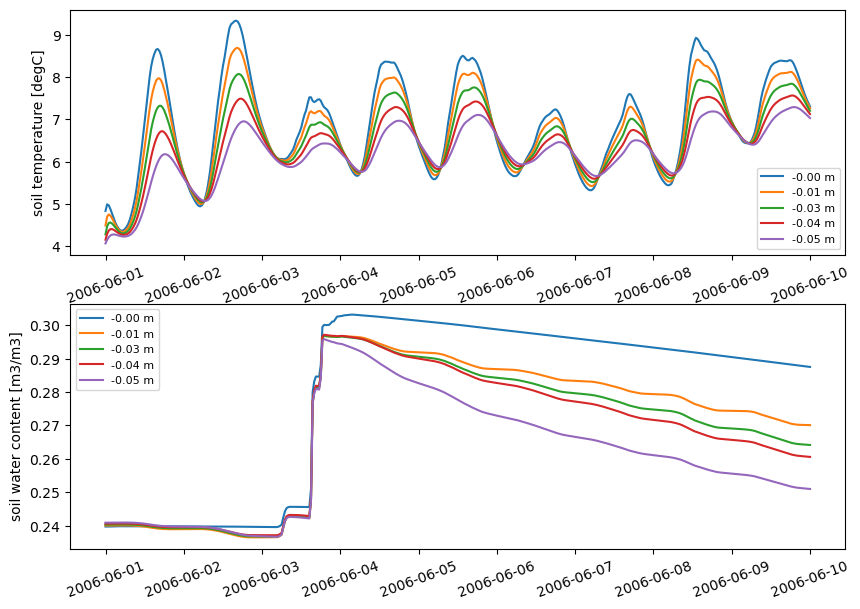

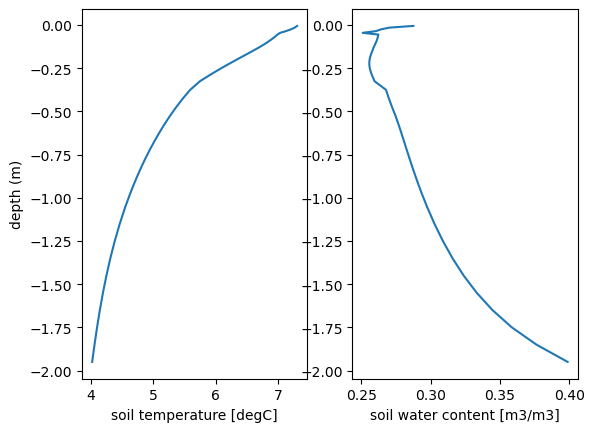

In [35]:
import numpy as np
var = ['soil_temperature', 'soil_volumetric_water_content']

lyrs = [0, 1, 2, 3, 4] # five top layers
#depths = np.array2string(np.asarray(zs[lyrs]), precision=1, separator=', ')
depths = ['{:.2f} m'.format(k) for k in zs[lyrs]]

fig, ax = plt.subplots(2, 1, figsize=(10,7))

k = 0
for v in var:
    ax[k].plot(t, results[v][:,sim,lyrs], label=depths)
    ax[k].set_ylabel(results[v].attrs['units'])
    ax[k].tick_params(axis='x', labelrotation = 20)
    ax[k].legend(fontsize=8)
    k += 1

# vertical profile at last timestep
fig, ax = plt.subplots(1, 2) #figsize=(10,5))

k = 0
for v in var:
    ax[k].plot(results[v][-1,sim,:], zs)
    ax[k].set_xlabel(results[v].attrs['units'])
    ax[0].set_ylabel('depth (m)')
    k += 1